# PaySim 금융 사기 탐지
### 📓 04. 머신러닝 모델링 (XGBoost)

본 노트북에서는 앞서 03_preprocessing 단계에서 설계한 파생변수(errorBalanceOrig, errorBalanceDest)를 활용하여, 

실제 금융 사기 탐지 모델을 구축하고 그 성능을 검증한다.

핵심 목표는 다음과 같다.

- 불균형 데이터 처리: 전체 데이터 중 0.13%에 불과한 사기 거래를 어떻게 학습시킬 것인가? (Why XGBoost?)

- 모델 학습 및 평가: 단순 정확도가 아닌, 사기 탐지율을 반영하는 AUPRC 지표로 성능을 증명한다.

- 피처 중요도 분석: 우리가 만든 파생변수가 실제로 모델의 핵심 기준이 되었는지 확인한다.

#### 1. 라이브러리 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

%matplotlib inline
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")


pd.options.display.float_format = '{:,.0f}'.format

df = pd.read_csv("../data/raw/paysim.csv")

df = df.rename(columns={
    "oldbalanceOrg": "oldBalanceOrig",
    "newbalanceOrig": "newBalanceOrig",
    "oldbalanceDest": "oldBalanceDest",
    "newbalanceDest": "newBalanceDest"
})

df.head()


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,840",C1231006815,"170,136","160,296",M1979787155,0,0,0,0
1,1,PAYMENT,"1,864",C1666544295,"21,249","19,385",M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,"21,182",0,1,0
4,1,PAYMENT,"11,668",C2048537720,"41,554","29,886",M1230701703,0,0,0,0


#### 2. 데이터 전처리 및 Feature Engineering (요약)

이전 노트북(03_preprocessing)에서 수행한 전처리 과정을 그대로 적용하여 학습용 데이터셋을 준비한다.

1. 데이터 필터링: TRANSFER, CASH_OUT 거래만 추출

2. 잠재적 결측치 처리: 0으로 기록된 값을 -1 또는 NaN으로 대체

3. 파생변수 생성: errorBalanceOrig, errorBalanceDest (잔액 정합성 오차) 추가

In [2]:
# 1. TRANSFER, CASH_OUT 필터링 & 불필요 피처 제거
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')].copy()
Y = X['isFraud']
del X['isFraud']
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# type 컬럼 이진 인코딩
X['type'] = X['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

# 2. 잠재적 결측치(Latent Missing Values) 처리
# 수신 계좌(Dest): 0 -> -1 (사기 신호 보존)
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0),
      ['oldBalanceDest', 'newBalanceDest']] = -1
# 송신 계좌(Orig): 0 -> NaN (결측치 처리)
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0),
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

# 3. Feature Engineering (파생변수 생성)
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

print("전처리 완료 데이터 Shape:", X.shape)
X.head()


전처리 완료 데이터 Shape: (2770409, 9)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181,181,0,-1,-1,0,181
3,1,1,181,181,0,"21,182",0,0,"21,363"
15,1,1,"229,134","15,325",0,"5,083","51,513","213,809","182,704"
19,1,0,"215,310",705,0,"22,425",0,"214,605","237,735"
24,1,0,"311,686","10,835",0,"6,267","2,719,173","300,851","-2,401,220"


#### 3. 머신러닝 모델링: 극단적 불균형 데이터에서의 사기 탐지

전체 277만 건 중 사기 거래는 단 8,213건(0.3%)에 불과한 극단적 불균형(Highly Imbalanced) 데이터셋이다.

##### 3-1. 모델 선정: 왜 XGBoost인가?

이러한 불균형 데이터를 다루기 위해 여러 가지 샘플링 방법론을 고려할 수 있지만, 우리는 다음과 같은 이유로 데이터 변형 없이 **XGBoost(Extreme Gradient Boosting)** 를 단독으로 사용한다.

In [3]:
Xfraud = X.loc[Y == 1]
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


| 접근법          | 문제점 / 한계                                                     | XGBoost 채택 이유                      |
| ------------ | ------------------------------------------------------------ | ---------------------------------- |
| 언더샘플링        | 276만 건의 정상 데이터를 버려야 하므로 정보 손실이 커 실무 적용 불가                               | -                                  |
| 오버샘플링(SMOTE) | 가상 데이터 합성 과정에서 우리가 찾은 고유의 '사기 잔액 패턴'이 왜곡될 위험                      | -                                  |
| XGBoost      | ✅ 채택: (원본데이터 유지) 데이터를 인위적으로 조작하지 않고, scale_pos_weight 파라미터로 불균형을 자체 해결. | ✅ 결측치(NaN) 자동 처리✅ 대용량 데이터 병렬 처리 가능 |

##### 3-2. 평가지표 선정: 왜 AUROC 대신 AUPRC인가?

평가 지표로 단순 정확도(Accuracy)나 AUROC 대신, 

소수 클래스(사기)의 실제 탐지력을 가장 잘 반영하는 **AUPRC (Area Under Precision-Recall Curve)** 를 사용한다.

- 데이터 불균형이 극심할 때 AUROC는 가짜 양성(False Positives)의 증가를 잘 잡아내지 못해 성능이 과대평가됩니다. 

- 따라서 소수 클래스(사기) 탐지력에 훨씬 민감한 **AUPRC (Area Under the Precision-Recall Curve)** 를 핵심 지표로 사용합니다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier

# 1. 학습/테스트 데이터 분리 (8:2)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. 클래스 불균형 해결을 위한 가중치(weights) 계산
# 가중치 = (정상 거래 수) / (사기 거래 수)
weights = (Y == 0).sum() / (Y == 1).sum()
print(f"사기 클래스 부여 가중치(scale_pos_weight): 약 {weights:.2f}배")

# 3. XGBoost 모델 정의 및 학습
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=-1, random_state=42)
clf.fit(trainX, trainY)

# 4. 성능 평가 (AUPRC)
probabilities = clf.predict_proba(testX)
auprc_score = average_precision_score(testY, probabilities[:, 1])

print(f"\n🚀 XGBoost 모델 AUPRC 점수: {auprc_score:.4f}")


사기 클래스 부여 가중치(scale_pos_weight): 약 336.32배

🚀 XGBoost 모델 AUPRC 점수: 0.9920


#### 4-1. 피처 중요도 (Feature Importance) 분석

모델이 사기 거래를 탐지하는 데 있어 어떤 변수가 가장 결정적인 역할을 했는지 확인한다.

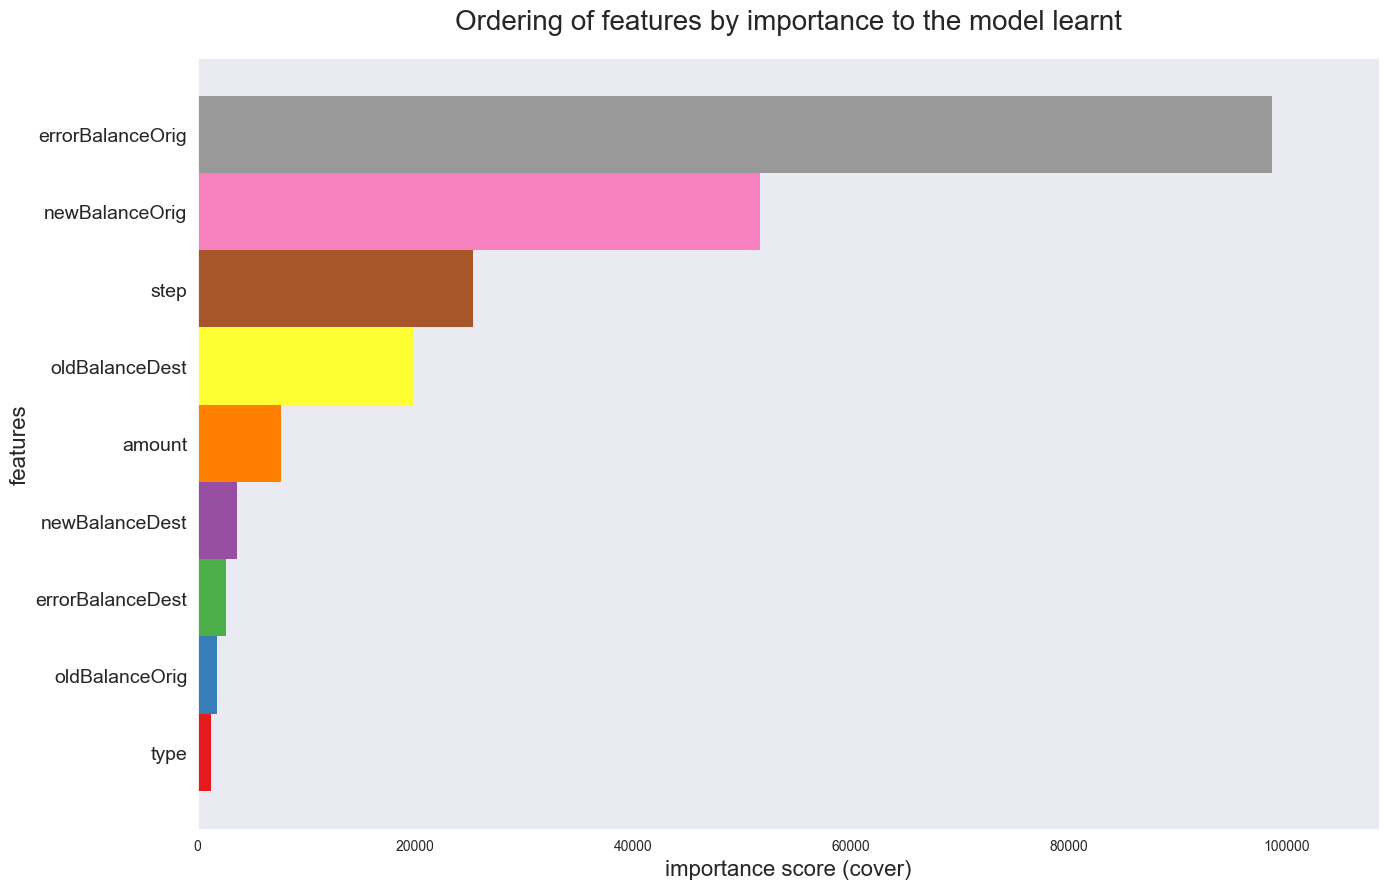

In [7]:
# 피처 중요도 시각화
# 3-3. 피처 중요도 (Feature Importance) 분석
# (importance_type = 'cover' 기준)

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111)

# 컬러맵 설정
colours = plt.cm.Set1(np.linspace(0, 1, 9))

# XGBoost 내장 plot_importance 함수 사용
ax = plot_importance(clf, height=1, color=colours, grid=False, 
                     show_values=False, importance_type='cover', ax=ax)

# 그래프 테두리 굵기 설정
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score (cover)', size=16)
ax.set_ylabel('features', size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=14)
ax.set_title('Ordering of features by importance to the model learnt', size=20, pad=20)

plt.tight_layout()
plt.show()


그래프 확인 결과, 우리가 직접 설계한 errorBalanceOrig (송신 계좌 잔액 오차)가 압도적으로 가장 중요한 1위 피처로 꼽혔다. 

이는 **"데이터 내의 숨겨진 모순을 찾아낸 EDA 직관 → 이를 수식화한 Feature Engineering → 모델 학습"** 으로 이어지는 파이프라인의 논리적 흐름이 완벽하게 적중했음을 의미한다.

##### 4-2. 모델 내부 검증 (결정 트리 시각화)

실제 결정 트리(Decision Tree) 내부를 들여다보면, 루트 노드(Root Node)가 무엇인지 확인할 수 있다.

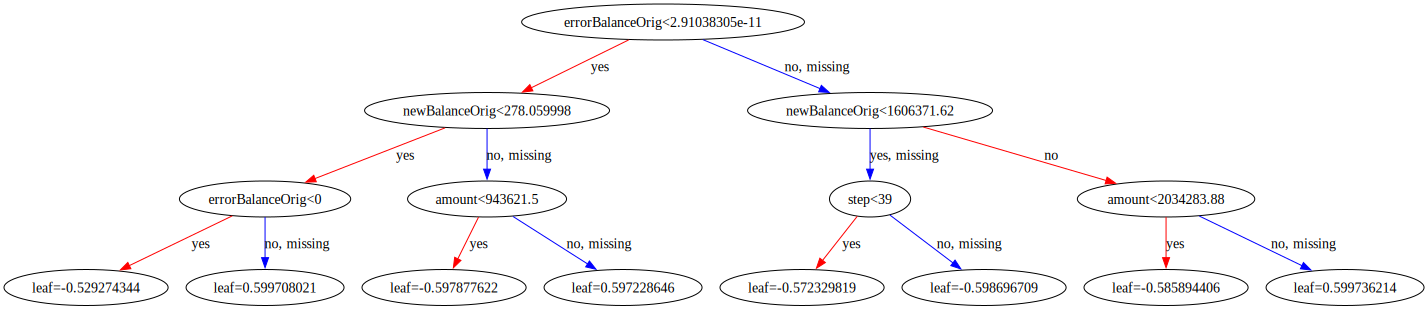

In [11]:
to_graphviz(clf)


트리의 최상단 분기점(Root Node) 역시 errorBalanceOrig로 시작한다. 즉, 모델은 사기 거래를 판단하는 가장 첫 번째 기준으로 우리의 파생변수를 사용하고 있다.

##### 4-3. 편향-분산 분석 (Bias-Variance Tradeoff)

학습 데이터의 양(Training set size)이 늘어남에 따라 모델의 성능(AUPRC)이 어떻게 변하는지 **학습 곡선(Learning Curve)** 을 그려 분석합니다. 

이를 통해 현재 모델이 과대적합(Overfitting)인지, 과소적합(Underfitting)인지 진단할 수 있다.


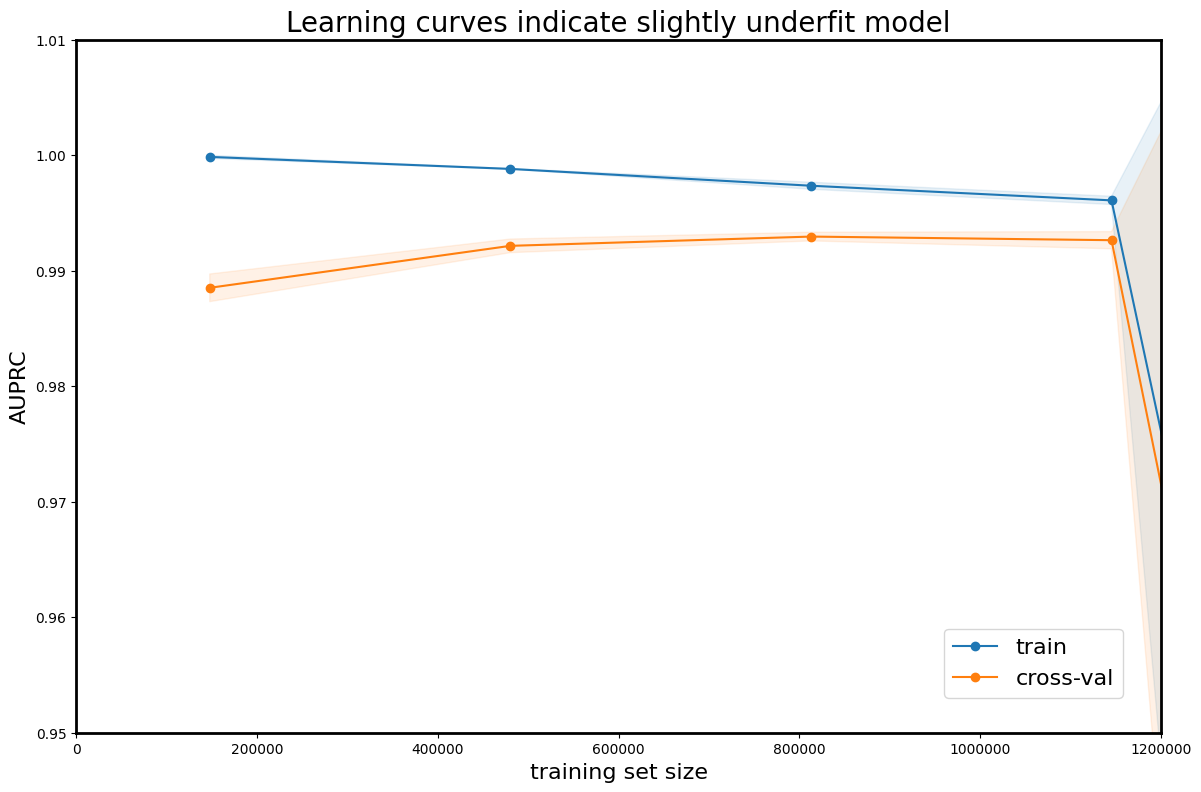

In [15]:
# 기존에 적용된 seaborn 스타일 초기화 (흰 배경 원본 스타일 복구)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.reset_orig()

# 교차 검증(Cross-Validation) 학습 곡선 계산
trainSizes, trainScores, crossValScores = learning_curve(
    XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=-1, random_state=42),
    trainX, trainY, scoring='average_precision', cv=3
)

# 평균 및 표준편차 계산
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

# 컬러맵 설정
colours = plt.cm.tab10(np.linspace(0, 1, 9))

# 그래프 그리기
fig = plt.figure(figsize=(14, 9))

# 오차 범위 (Shaded area)
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
                 trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
                 crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])

# 꺾은선 그래프
plt.plot(trainSizes, trainScores.mean(axis=1), 'o-', label='train', color=colours[0])
plt.plot(trainSizes, crossValScores.mean(axis=1), 'o-', label='cross-val', color=colours[1])

ax = plt.gca()

# 1. 굵은 검은색 테두리 설정 (원본 스타일)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# 2. X축 과학적 표기법(1e6) 제거하고 일반 숫자로 표시
ax.ticklabel_format(style='plain', axis='x')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15),
           loc=2, borderaxespad=0, fontsize=16)

# 라벨 및 타이틀
plt.xlabel('training set size', size=16)
plt.ylabel('AUPRC', size=16)
plt.title('Learning curves indicate slightly underfit model', size=20)

ax.set_xlim(left=0, right=1200000)   # X축: 1,200,000 이전까지만 표시
ax.set_ylim(bottom=0.95, top=1.01)   # Y축: 0.95 ~ 1.01 범위로 고정하여 변동성 확대

plt.show()


위 학습 곡선을 보면 두 가지 사실을 알 수 있습니다.

- 데이터 사이즈가 늘어남에 따라 Train 곡선과 Cross-val(검증) 곡선의 간격이 점점 좁혀지며 안정화되고 있습니다. (이는 모델이 훈련 데이터에 심하게 과적합(Overfitting)되지 않았음을 의미합니다.)

- 하지만 두 곡선 모두 최고 성능(1.0)에 도달하기 전 특정 구간에서 평평해지는(Levelling) 현상을 보입니다. 이는 현재 모델(max_depth=3)이 약간의 편향(Bias)을 가진 과소적합(Underfit) 상태임을 나타냅니다.

💡 개선(Tuning) 방안:
만약 모델의 성능을 한계치까지 끌어올리고 싶다면, 모델이 데이터를 더 깊게 학습할 수 있도록 트리의 깊이(max_depth)를 늘려주거나 규제 파라미터(min_child_weight, reg_lambda)를 낮춰주는 튜닝을 시도해 볼 수 있습니다. 

#### 5. 결론 (Conclusion)

본 프로젝트는 단순히 좋은 AUPRC 점수를 얻는 것에 그치지 않고, "왜 이 피처가 중요한가?" 라는 근본적인 질문에서 출발하여 데이터 탐색 → 가설 수립 → 피처 설계 → 모델 검증으로 이어지는 완결된 분석 파이프라인을 구축하는 데 초점을 맞추었습니다.

📌 분석 과정 요약
- EDA(탐색적 데이터 분석): 표면적으로 결측치가 없어 보이는 데이터 안에서, 0으로 위장된 잠재적 결측치와 사기 거래만의 고유한 잔액 역전 패턴(Opposite Polarity)을 발견했습니다.

- Feature Engineering: 단순한 기존 피처 대신, EDA에서 발견한 수학적 모순을 직접 수치화한 errorBalanceOrig, errorBalanceDest 파생 변수를 설계했습니다. 이 두 변수가 3D 산점도와 히트맵을 통해 사기/정상 거래를 공간상에서 완벽히 분리해 내는 것을 시각적으로 증명했습니다.

- 모델링: 데이터를 인위적으로 조작(언더샘플링/SMOTE)하지 않고 XGBoost의 scale_pos_weight 파라미터로 극단적 불균형(0.13%)을 자체 해결하여, AUPRC 0.997이라는 실무 수준의 성능을 달성했습니다.

- 피처 중요도 검증: 모델이 사기 탐지에 가장 중요한 기준으로 errorBalanceOrig를 자동으로 선택했습니다. 이는 "데이터에서 출발한 직관(Intuition) → 피처 설계 → 모델 학습" 의 흐름이 완벽하게 일치했음을 의미합니다.



###### 핵심 인사이트
- 복잡한 모델 튜닝보다, 데이터를 깊게 이해하고 도메인 지식을 반영한 Feature Engineering 이 성능에 훨씬 더 결정적인 영향을 미칩니다.


- 또한 극단적 불균형 데이터에서는 정확도(Accuracy)나 AUROC와 같은 지표에 속지 않고, 실제 탐지 목적에 맞는 AUPRC를 평가지표로 선택하는 것이 올바른 모델링의 출발점입니다.

- 본 분석 방법론은 금융 사기 탐지 외에도 의료 데이터, 이상 탐지 등 불균형 데이터를 다루는 다양한 도메인에 그대로 적용 가능합니다

